# MPAL1

Karyotype/Cytogenetics:
```
45,XY,del(6)(q13q21),-7,-8,-9,add(16)(p13),+2mar[cp19]/
46,XY[1]
```
Explanation (ref. https://en.wikipedia.org/wiki/Cytogenetic_notation): 
- 19 cells are coposite (mixed up), with a deletion of chromosome 7, 8, and 9 (i.e., only one copy of 7, 8, and 9 are left). A small deletion on 6 and a addition on 16. A portion of 2 is shown.
- 1 cell is normal (i.e., it has two copies of each chromosome, except for XY).

Thus, we expect to see bimodal distribution on Chr7, 8, and 9.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Relative Number

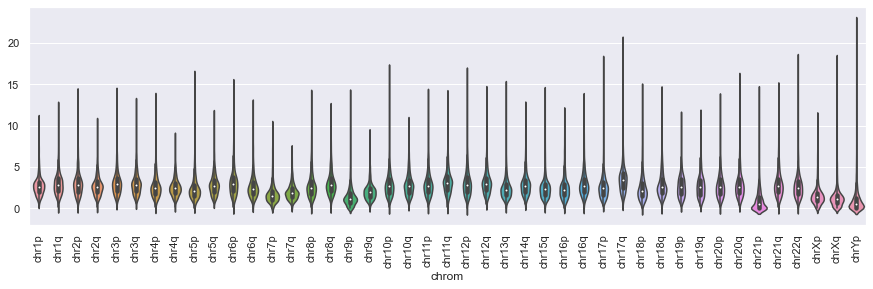

In [2]:
cnv_df_copyscat_relative = pd.read_csv("results/GSM4138898_scATAC_MPAL1_T1_intermediate0.csv", index_col=0).T
sns.set(rc={'figure.figsize':(15,4)})
g = sns.violinplot(data=cnv_df_copyscat_relative)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
pass # suppress output

## CopyscAT produced absolute number

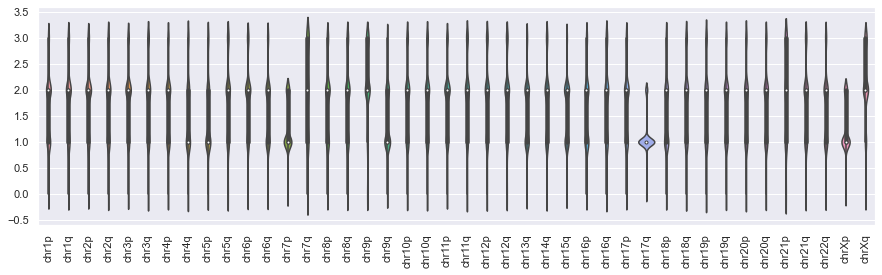

In [3]:
cnv_df_copyscat_absolute = pd.read_csv("results/GSM4138898_scATAC_MPAL1_T1_intermeiate1.csv", index_col=0)
sns.set(rc={'figure.figsize':(15,4)})
g = sns.violinplot(data=cnv_df_copyscat_absolute)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
pass # suppress output

## Investigate chr7p

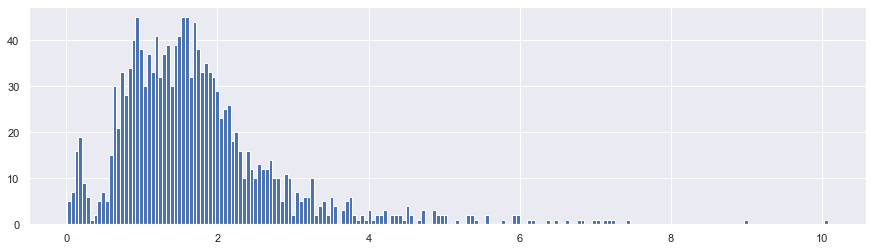

In [4]:
cnv_df_copyscat_relative.chr7p.hist(bins=200)

## Fourier transform of deterministic signal
$\delta(\bullet)$ is Dirac delta (impulses). It is a generalized (i.e., strange) function with following properties
$$\delta(x) = \begin{equation}
\left\{ 
  \begin{aligned}
    &\infty, &x = 0\\
    &0, &\text{otherwise}
  \end{aligned}
  \right.
\end{equation}$$

$$\int_{-\infty}^\infty \delta(x) dx = 1$$

$$f*\delta = \int_{-\infty}^\infty f(s)\delta(x - s) ds = f(x)$$

Our signal is defined as a series of delta functions.
$$f(x) = \sum_i\delta(x-x_i)$$

The continous time Fourier transform is defined as
$$F(\omega)=\mathcal{F}_x[f(x)](\omega)=\int_{-\infty}^{\infty}f(x)e^{i\omega x}$$

Thus, the transformation of our signal can be written as
$$F(\omega)=\mathcal{F}_x[\sum_i\delta(x-x_i)](\omega)=\sum_i\mathcal{F}_x[\delta(x-x_i)](\omega)=\sum_ie^{i\omega x_i}$$


It is the frequency domain representation (spectrum) of our signal. We show the spetrum by finding its value at a list of frequencies, and plot it.

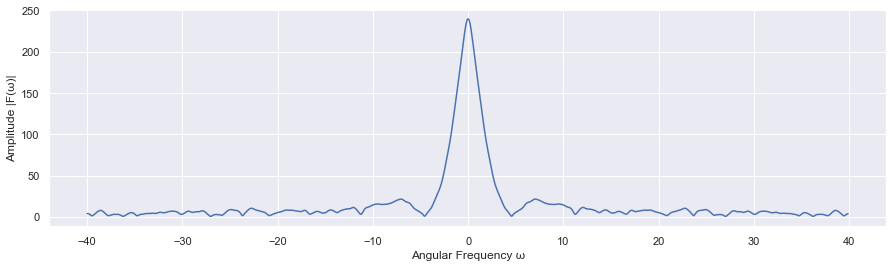

In [5]:
w_list = np.arange(-40, 40, 0.1)
y_list = (np.exp(1j * w_list.reshape([-1, 1]) * cnv_df_copyscat_relative.chr7p.to_numpy().reshape([1, -1]))).sum(axis=1) / (2 * np.pi)

# We need to take abs because the transformed signal is complex. Here we care about its magnitude.
y_list = abs(y_list)
    
plt.plot(w_list, y_list)

plt.xlabel("Angular Frequency ω")
plt.ylabel("Amplitude |F(ω)|")
pass

By default, the transformation gives us angular frequency. We divide it by $2\pi$ to obtain the frequency.

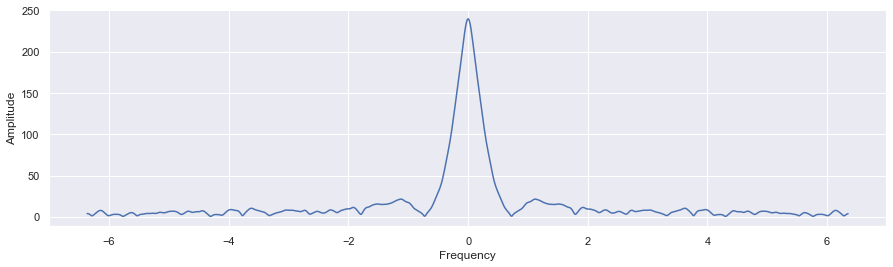

In [6]:
plt.plot(w_list / (2 * np.pi), y_list)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
pass

We can also take the reciprocal of the frequency to get the period, although the graph would look a bit strange. That said, we can overlay it with our histograph now.

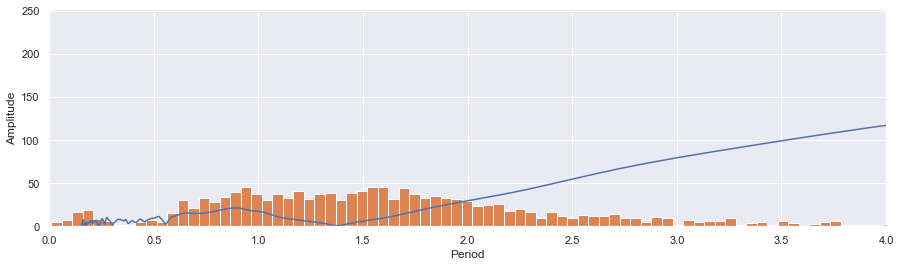

In [7]:
plt.plot((2 * np.pi) / w_list[w_list > 0], y_list[w_list > 0])
plt.xlim([0, 4])
plt.xlabel("Period")
plt.ylabel("Amplitude")
cnv_df_copyscat_relative.chr7p.hist(bins=200)
pass

## Forier transform of autocorrelation function

The autocorrelation function of a deterministic signal is defined as
$$R_f(s) = \int_{-\infty}^{\infty} f(x)f(x+s)dx .$$

By plugging in
$$f(x) = \sum_i\delta(x-x_i)$$
we have
$$R_f(s) = \int_{-\infty}^{\infty} \sum_i\delta(x-x_i) \sum_i\delta(x+s-x_i) dx.$$

Using the properties of $\delta$ function, we have
$$R_f(s) = \sum_i\sum_j \int_{-\infty}^{\infty} \delta(x-x_i) \delta(x+s-x_j) dx = \sum_i\sum_j \delta(x_j - s - x_i) = \sum_i\sum_j \delta(s - (x_j - x_i)).$$

Thus, the power spectrum density (PSD) can be figured out by
$$P = \mathcal{F}_s[\sum_i\sum_j \delta(s - (x_j - x_i))](\omega)=\sum_i\sum_j\mathcal{F}_x[\delta(s - (x_j - x_i))](\omega)=\sum_i\sum_j e^{i\omega (x_j - x_i)}$$

In [8]:
xs = cnv_df_copyscat_relative.chr7p.to_numpy()
outer_diff = (xs.reshape([1, -1]) - xs.reshape([-1, 1])).reshape([1, -1])

In [9]:
w_list = np.arange(-40, 40, 0.1)

In [10]:
P_list =(np.exp(1j * w_list.reshape([-1, 1]) * outer_diff)).sum(axis=1) / (2 * np.pi)

MemoryError: Unable to allocate 27.1 GiB for an array with shape (800, 2274064) and data type complex128

In [ ]:
# Note that P is mathematically guaranteed to be real (imaginary part is always 0).
# However, due to numerical issues, we have to take the real part. The imaginary part is usually something like 1e-10.
P_list = np.real(P_list)
plt.plot(w_list, P_list)

plt.xlabel("Angular Frequency ω")
plt.ylabel("P(ω)")
pass

In [ ]:
plt.plot(w_list / (2 * np.pi), P_list)
plt.xlabel("Frequency")
plt.ylabel("P(ω)")
pass

What if we take the square root of it?

In [11]:
P_list = np.real(P_list)
plt.plot(w_list, np.sqrt(P_list))

plt.xlabel("Angular Frequency ω")
plt.ylabel("P(ω)")
pass

NameError: name 'P_list' is not defined

It is not coincidence that it looks exactly the same as $\mathcal{F}[f]$. This is what Wiener–Khinchin theorem tells.

## Smoothing + FFT (Fast Fourier transform)

The previous analysis are based on continuous Fourier transform

Now we try to smooth the signal to obtain a evenly sampled signal, using a Gaussian kernel $\varphi$ (variance of choice; omitted for simplicity).
$$g(x) = f*\varphi = \int_{-\infty}^\infty f(s)\varphi(x-s) ds$$
$$g(x) = f*\varphi = \int_{-\infty}^\infty \sum_i\delta(s-x_i)\varphi(x-s) ds = \sum_i \varphi(x-x_i)$$

So it's basically adding up Gaussian PDFs located at each of the impulses.

In fact, one way to understand dirac delta is to imagine it as $\delta(x) = \lim_{a \rightarrow \infty}a\varphi(ax)$. Recall the properties we see above. It should be more relatable now.

$$\delta(0) = \infty$$

$$\delta(x) = 0 \text{ if } x \neq 0$$

$$\int_{-\infty}^\infty \delta(x) dx = 1$$

$$f*\delta = \int_{-\infty}^\infty f(s)\delta(x - s) ds = f(x)$$

After doing FFT, we can decompose the signal in the frequency domain and separate the signal into high and low frequency parts.

C:\Users\SLiang3\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\SLiang3\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Low frequency component')

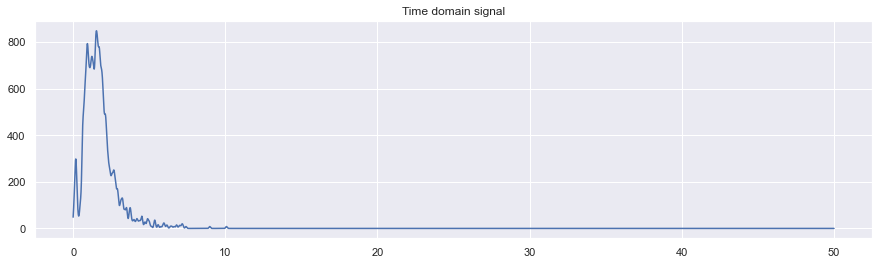

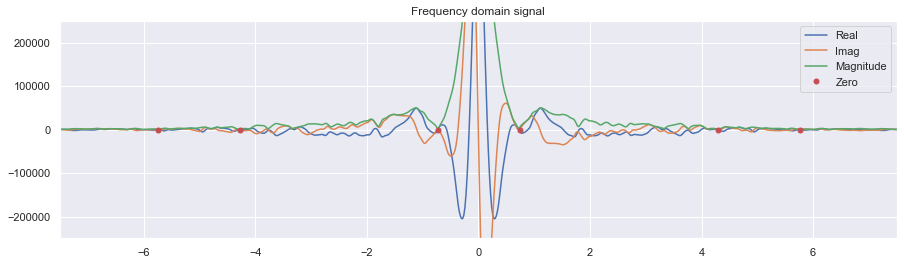

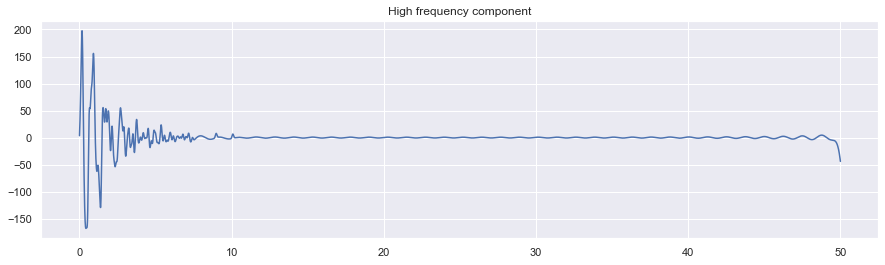

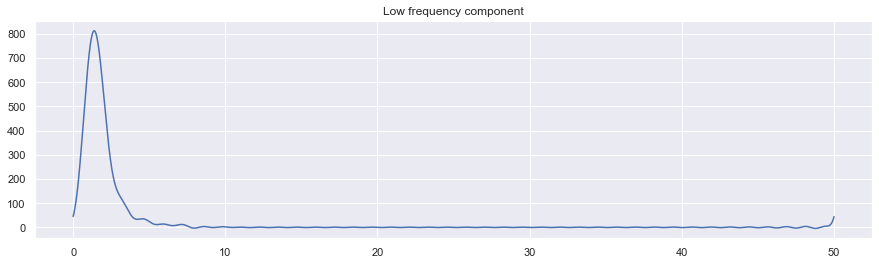

In [18]:
import scipy.stats
n_samples = 20001
xlim = [0, 50]
sampling_rate = n_samples / (xlim[1] - xlim[0])

x = np.linspace(*xlim, n_samples).reshape([-1, 1])
smoothed_signal = scipy.stats.norm.pdf(x, cnv_df_copyscat_relative.chr7p.to_numpy().reshape([1, -1]), 0.05).sum(axis=1)
plt.plot(x, smoothed_signal)
plt.title("Time domain signal")

n_fft = 20001
y = np.fft.fft(smoothed_signal, n_fft)
shifted_y = np.fft.fftshift(y)
shifted_freq = np.arange(- (n_fft // 2), (n_fft // 2) + (n_fft % 2)) * (sampling_rate / n_fft)
plt.figure()
plt.plot(shifted_freq, shifted_y.real)
plt.plot(shifted_freq, shifted_y.imag)
plt.plot(shifted_freq, np.abs(shifted_y))

y_zero = ((shifted_y.real[:-1] < 0) != (shifted_y.real[1:] < 0)) & ((shifted_y.imag[:-1] < 0) != (shifted_y.imag[1:] < 0))
shifted_freq[np.hstack([False, y_zero])]

zero_points = shifted_freq[np.hstack([False, y_zero])]
plt.plot(zero_points, np.zeros(zero_points.shape), 'o', ms=5)
plt.legend(['Real', 'Imag', 'Magnitude', "Zero"])
plt.xlim(-7.5, 7.5)
plt.ylim(-250000, 250000)
plt.title("Frequency domain signal")

# Plot high freq component
shifted_high_y = shifted_y.copy()
shifted_high_y[(abs(shifted_freq) < 0.81)] = 0
high_y = np.fft.ifftshift(shifted_high_y)
high_signal = np.fft.ifft(high_y)
plt.figure()
plt.plot(x, high_signal)
plt.title("High frequency component")


# Plot low freq component
shifted_low_y = shifted_y.copy()
shifted_low_y[(abs(shifted_freq) >= 0.81)] = 0
low_y = np.fft.ifftshift(shifted_low_y)
low_signal = np.fft.ifft(low_y)
plt.figure()
plt.plot(x, low_signal)
plt.title("Low frequency component")

Text(0.5, 1.0, 'Wiener filteredsignal')

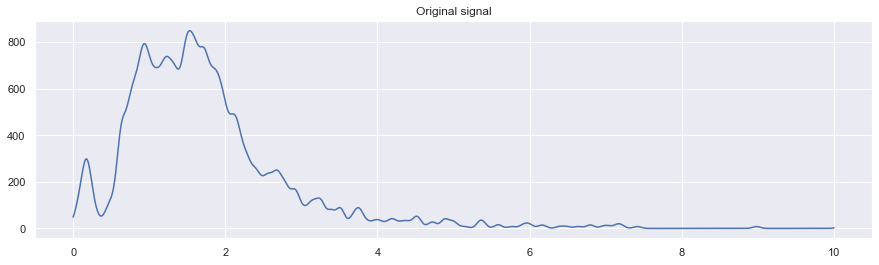

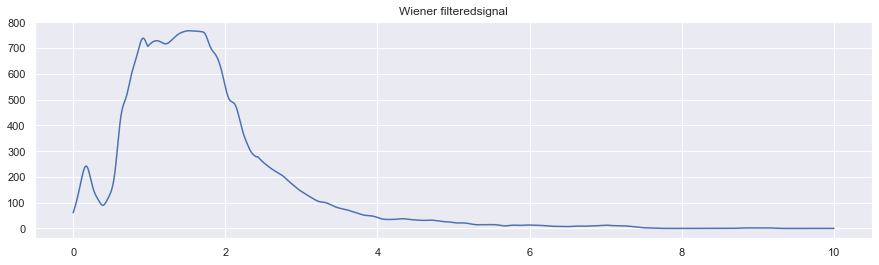

In [45]:
import scipy.signal

n_samples = 10001
xlim = [0, 10]
sampling_rate = n_samples / (xlim[1] - xlim[0])

x = np.linspace(*xlim, n_samples).reshape([-1, 1])
smoothed_signal = scipy.stats.norm.pdf(x, cnv_df_copyscat_relative.chr7p.to_numpy().reshape([1, -1]), 0.05).sum(axis=1)
plt.figure()
plt.plot(x, smoothed_signal)
plt.title("Original signal")

wiener_signal = scipy.signal.wiener(smoothed_signal, mysize=500)

plt.figure()
plt.plot(x, wiener_signal)
plt.title("Wiener filteredsignal")

Text(0.5, 1.0, 'Wiener Frequency domain signal')

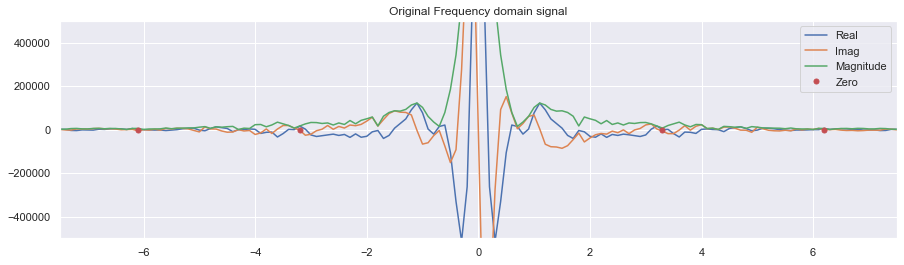

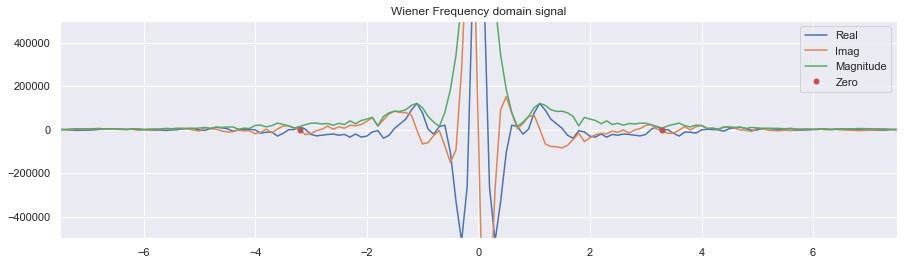

In [40]:
n_fft = 10001
y = np.fft.fft(smoothed_signal, n_fft)
shifted_y = np.fft.fftshift(y)
shifted_freq = np.arange(- (n_fft // 2), (n_fft // 2) + (n_fft % 2)) * (sampling_rate / n_fft)
plt.figure()
plt.plot(shifted_freq, shifted_y.real)
plt.plot(shifted_freq, shifted_y.imag)
plt.plot(shifted_freq, np.abs(shifted_y))

y_zero = ((shifted_y.real[:-1] < 0) != (shifted_y.real[1:] < 0)) & ((shifted_y.imag[:-1] < 0) != (shifted_y.imag[1:] < 0))
shifted_freq[np.hstack([False, y_zero])]

zero_points = shifted_freq[np.hstack([False, y_zero])]
plt.plot(zero_points, np.zeros(zero_points.shape), 'o', ms=5)
plt.legend(['Real', 'Imag', 'Magnitude', "Zero"])
plt.xlim(-7.5, 7.5)
plt.ylim(-500000, 500000)
plt.title("Original Frequency domain signal")

n_fft = 10001
y = np.fft.fft(wiener_signal, n_fft)
shifted_y = np.fft.fftshift(y)
shifted_freq = np.arange(- (n_fft // 2), (n_fft // 2) + (n_fft % 2)) * (sampling_rate / n_fft)
plt.figure()
plt.plot(shifted_freq, shifted_y.real)
plt.plot(shifted_freq, shifted_y.imag)
plt.plot(shifted_freq, np.abs(shifted_y))

y_zero = ((shifted_y.real[:-1] < 0) != (shifted_y.real[1:] < 0)) & ((shifted_y.imag[:-1] < 0) != (shifted_y.imag[1:] < 0))
shifted_freq[np.hstack([False, y_zero])]

zero_points = shifted_freq[np.hstack([False, y_zero])]
plt.plot(zero_points, np.zeros(zero_points.shape), 'o', ms=5)
plt.legend(['Real', 'Imag', 'Magnitude', "Zero"])
plt.xlim(-7.5, 7.5)
plt.ylim(-500000, 500000)
plt.title("Wiener Frequency domain signal")

It seems that we can better see the periodicity in the high frequency component.

Just to mention, if we add the high and low frequency signals together, we can recover the original signal.

C:\Users\SLiang3\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'High + Low frequency components = original signal')

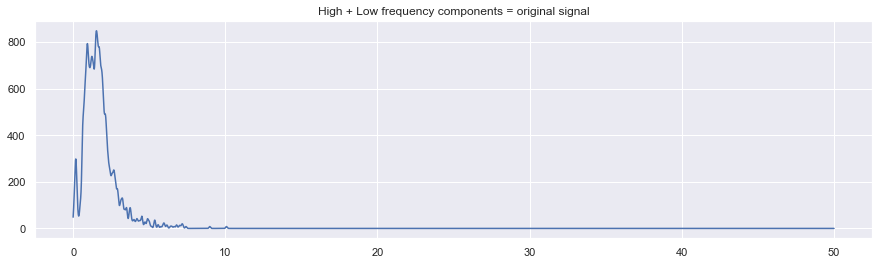

In [13]:
plt.figure()
plt.plot(x, low_signal + high_signal)
plt.title("High + Low frequency components = original signal")

C:\Users\SLiang3\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\SLiang3\Miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Low frequency component')

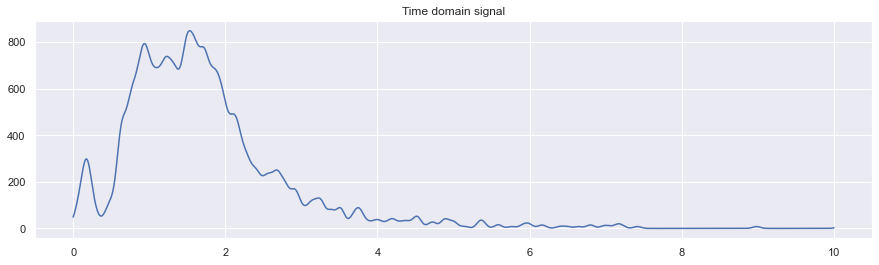

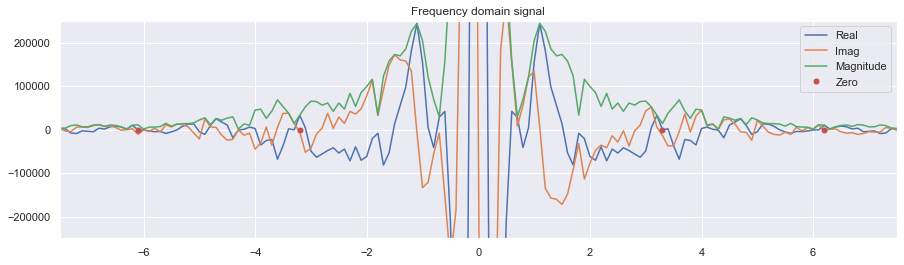

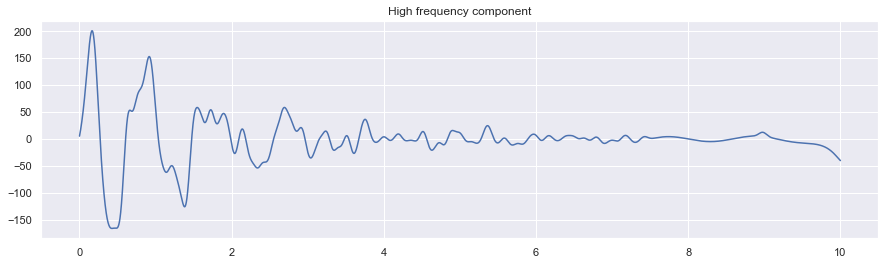

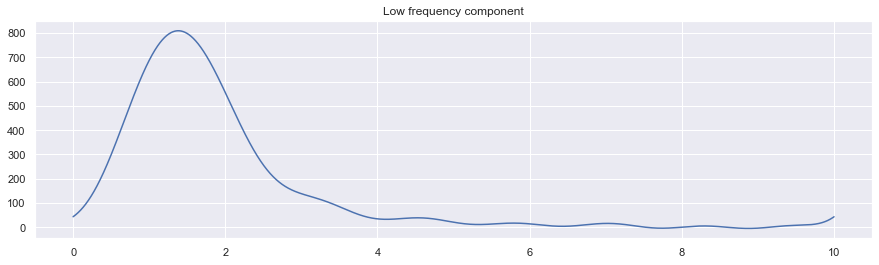

In [14]:
# Increase sampling rate to see if it makes things better.

import scipy.stats
n_samples = 20001
xlim = [0, 10]
sampling_rate = n_samples / (xlim[1] - xlim[0])

x = np.linspace(*xlim, n_samples).reshape([-1, 1])
smoothed_signal = scipy.stats.norm.pdf(x, cnv_df_copyscat_relative.chr7p.to_numpy().reshape([1, -1]), 0.05).sum(axis=1)
plt.plot(x, smoothed_signal)
plt.title("Time domain signal")

n_fft = 20001
y = np.fft.fft(smoothed_signal, n_fft)
shifted_y = np.fft.fftshift(y)
shifted_freq = np.arange(- (n_fft // 2), (n_fft // 2) + (n_fft % 2)) * (sampling_rate / n_fft)
plt.figure()
plt.plot(shifted_freq, shifted_y.real)
plt.plot(shifted_freq, shifted_y.imag)
plt.plot(shifted_freq, np.abs(shifted_y))

y_zero = ((shifted_y.real[:-1] < 0) != (shifted_y.real[1:] < 0)) & ((shifted_y.imag[:-1] < 0) != (shifted_y.imag[1:] < 0))
shifted_freq[np.hstack([False, y_zero])]

zero_points = shifted_freq[np.hstack([False, y_zero])]
plt.plot(zero_points, np.zeros(zero_points.shape), 'o', ms=5)
plt.legend(['Real', 'Imag', 'Magnitude', "Zero"])
plt.xlim(-7.5, 7.5)
plt.ylim(-250000, 250000)
plt.title("Frequency domain signal")

# Plot high freq component
shifted_high_y = shifted_y.copy()
shifted_high_y[(abs(shifted_freq) < 0.81)] = 0
high_y = np.fft.ifftshift(shifted_high_y)
high_signal = np.fft.ifft(high_y)
plt.figure()
plt.plot(x, high_signal)
plt.title("High frequency component")


# Plot low freq component
shifted_low_y = shifted_y.copy()
shifted_low_y[(abs(shifted_freq) >= 0.81)] = 0
low_y = np.fft.ifftshift(shifted_low_y)
low_signal = np.fft.ifft(low_y)
plt.figure()
plt.plot(x, low_signal)
plt.title("Low frequency component")

Text(0.5, 1.0, 'wiener_signal')

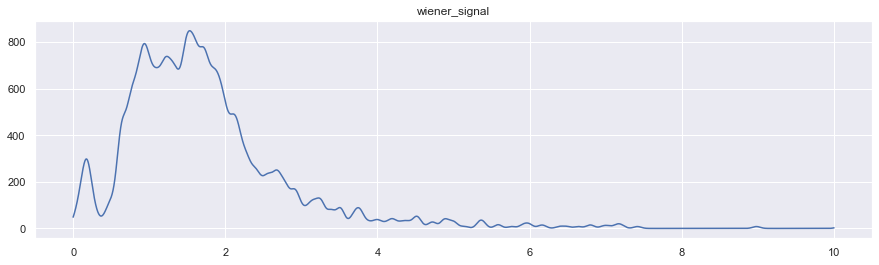

## Demo

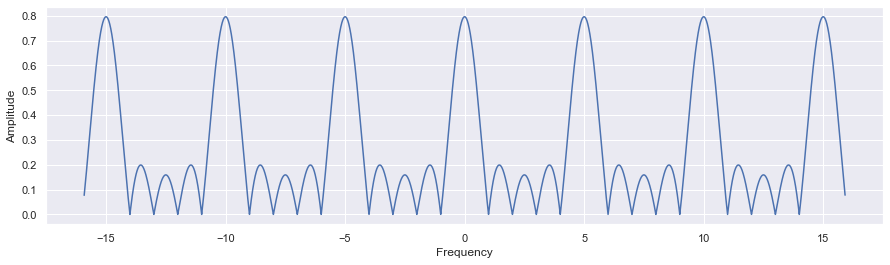

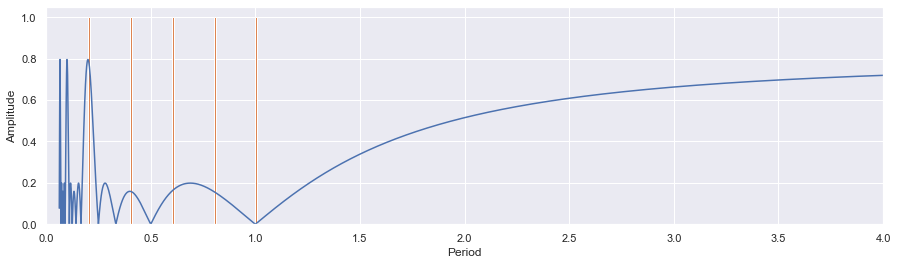

In [8]:
f = [0.2, 0.4, 0.6, 0.8, 1.0]
w_list = np.arange(-100, 100, 0.005)
y_list = (np.exp(1j * w_list.reshape([-1, 1]) * np.array(f).reshape([1, -1]))).sum(axis=1) / (2 * np.pi)
    
y_list = abs(y_list)

plt.plot(w_list / (2 * np.pi), y_list)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

plt.figure()

plt.plot((2 * np.pi) / w_list[w_list > 0], y_list[w_list > 0])
plt.xlim([0, 4.])
plt.xlabel("Period")
plt.ylabel("Amplitude")
plt.hist(f, bins=np.arange(0.0, 1.9, 0.01))
pass

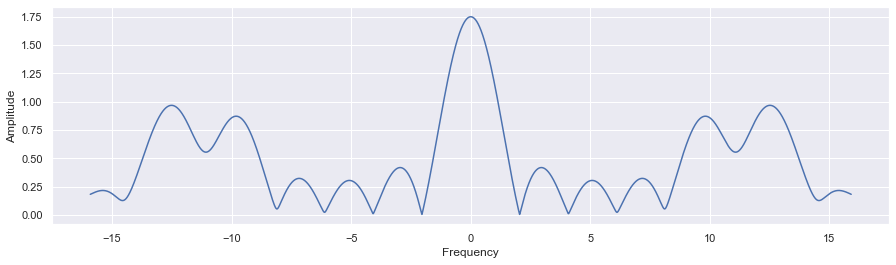

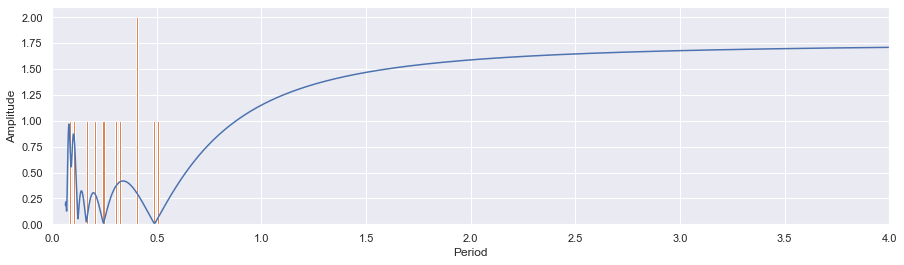

In [9]:
f = [0.1, 0.2, 0.3, 0.4, 0.5, 0.08, 0.16, 0.24, 0.32, 0.4, 0.48]
w_list = np.arange(-100, 100, 0.005)
y_list = (np.exp(1j * w_list.reshape([-1, 1]) * np.array(f).reshape([1, -1]))).sum(axis=1) / (2 * np.pi)
    
y_list = abs(y_list)

plt.plot(w_list / (2 * np.pi), y_list)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

plt.figure()

plt.plot((2 * np.pi) / w_list[w_list > 0], y_list[w_list > 0])
plt.xlim([0, 4.])
plt.xlabel("Period")
plt.ylabel("Amplitude")
plt.hist(f, bins=np.arange(0.0, 4.0, 0.01))
pass